## 权重衰退

- 通过限制特征的选择范围，来控制模型容量；
- 通常限制W，而不限制b，因为b限不限制影响不大。

### 1.范数与权重衰减

使用范数，来衡量W的复杂性，作为惩罚项（penalty）加到最小化损失函数的优化问题中。（类似拉格朗日乘子的形式，将刚性约束转为柔性约束）
$$
min ~ L(W,b) + \frac{\lambda}{2}||W||^2
$$
上面的形式方便在梯度反向传播时，对W求偏导。

超参数$\lambda$控制了正则项的重要程度：
- $\lambda = 0$：无作用
- $\lambda = \infty$：$||W||^2 \to 0$

倾向于首先使用$L_2$范数：
- $L_2$范数对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它对单个变量中的观测误差更为稳定。
- 而$L_1$范数会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。这称为特征选择（feature selection），这可能是其他场景下需要的。
- $L_2$正则化线性回归构成经典的岭回归（ridge regression）算法，$L_1$正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。

### 2.实现权重衰减

In [1]:
%matplotlib inline
import torch
from torch import nn
import sys
sys.path.append('..')
import d2l
import utils

生成数据：
$$
y = 0.05 + \sum_{i=1}^d 0.01x_i + \epsilon, ~ where ~ \epsilon \sim \mathcal{N}(0, 0.01^2)
$$
为了让权重衰退的作用更明显，将问题的维度d增加到200，但只给20个训练数据。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
print(true_w.shape)
print(true_b)
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

torch.Size([200, 1])
0.05


初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义$L_2$范数惩罚

In [4]:
def l2_penalty(W):
    '''L2范数惩罚项，平方和除2'''
    return torch.sum(W.pow(2)) / 2

训练

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = utils.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (utils.evaluate_loss(net, train_iter, loss),
                                     utils.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', torch.norm(w).item())

w的L2范数是: 11.511725425720215


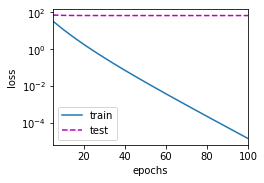

In [6]:
train(lambd=0)

w的L2范数是: 0.34880518913269043


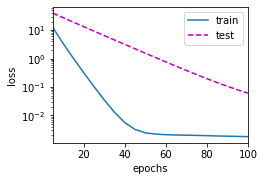

In [7]:
train(lambd=3)

### 3.简洁实现

In [8]:
def train_concise(wd):
    # 线性
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    # 标准正态分布初始化
    for param in net.parameters():
        param.data.normal_()
    # MSELoss
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 直接写在优化器里面
    trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
    animator = utils.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    # 训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (utils.evaluate_loss(net, train_iter, loss),
                          utils.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数:', net[0].weight.norm().item())

w的L2范数: 13.15665340423584


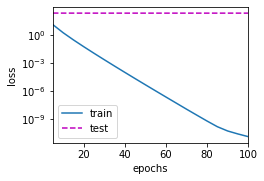

In [9]:
train_concise(0)

w的L2范数: 0.3783565163612366


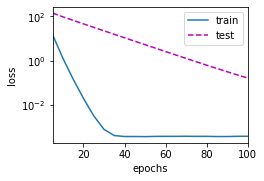

In [10]:
train_concise(3)